# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum-rand"

nb_devices_for_the_run = 20

# Data preparation

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
columns_with_missing_values = []
for col in range(1, len(data.columns)):
    if (not data[data[col] == 999].empty) or (not data[data[col] == 9999].empty):
        columns_with_missing_values.append(col)
print("Following columns has missing values :", columns_with_missing_values)
data.drop(data.columns[columns_with_missing_values],axis=1,inplace=True)
print("This columns has been removed.")
data = data.rename(columns={ 0: "ID", 1: "state", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

Following columns has missing values : [21, 22, 23, 30, 45, 46, 47, 56]
This columns has been removed.


,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [3]:
dim_notebook = len(data.columns) - 1 # We don't count as dimension the labels
print("There is " + str(dim_notebook) + " dimensions.")

There is 70 dimensions.


In [4]:
# Showing that there is empty columns (with null std).
small_std = []
std_data = data.std()
for i in range(len(data.columns)):
    if std_data.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
data.iloc[:,small_std].describe()

[40, 41, 42, 43, 44]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [5]:
# Removing columns with null std
data = data.loc[:, (data.std() > 1e-6)]
dim_notebook = len(data.columns) - 1
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 65 dimensions.


In [6]:
data = data.replace({'state': {0: -1}})
data.head()

,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,-1,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,-1,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [7]:
data['state'].value_counts()

-1    25139
 1    24861
Name: state, dtype: int64

# Handling non-iid data

In [ ]:
%%time
# Running TNSE to obtain a 2D representation of data
embedded_data = tsne(data)
pickle_saver(embedded_data, filename + "-tsne")

There is 2 devices.
Number of points on device 0 : 10279
Number of points on device 1 : 39721
CPU times: user 47.7 s, sys: 420 ms, total: 48.1 s
Wall time: 12.1 s


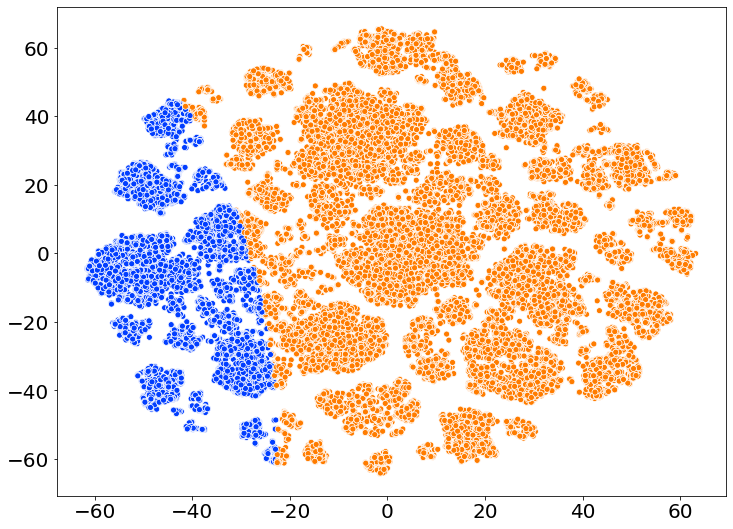

In [8]:
%%time
nb_cluster = 20
embedded_data = pickle_loader("quantum-tsne")
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "state", nb_cluster, scale_Y=False)
dim_notebook = X[0].shape[1]

In [ ]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [ ]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

In [9]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_cluster)

In [10]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_cluster,
                                                nb_epoch=5000, 
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
    1000 | 5.2670e-01
    2000 | 5.2643e-01
    3000 | 5.2641e-01
    4000 | 5.2640e-01
Gradient Descent: execution time=36.590 seconds
Final loss : 0.52640

CPU times: user 2min 24s, sys: 1.02 s, total: 2min 25s
Wall time: 36.6 s


In [11]:
step_formula = [(lambda it, L, omega, N: 20 / (2*L)),
                (lambda it, L, omega, N: 5 / L),
                (lambda it, L, omega, N: 2 / L),
                (lambda it, L, omega, N: 1 / L),
                (lambda it, L, omega, N: 1 / (2*L)),
                (lambda it, L, omega, N: 1 / (4*L)),
                (lambda it, L, omega, N: 1 / (8*L)),
                (lambda it, L, omega, N: 1 / (16*L)),
                (lambda it, L, omega, N: 1 / (32*L)),
                (lambda it, L, omega, N: 1 / (64*L)),
                ]

label_step_formula = ["N/2L",
                "5/L",
                "2/L",
                "$L^{-1}$",
                "$2L^{-1}$",
                "$4L^{-1}$",
                "$8L^{-1}$",
                "$16L^{-1}$",
                "$32L^{-1}$",
                "$64L^{-1}$",
                ]

## Batch size $= 400$

In [17]:
%%time
batch_size = 400
all_kind_of_compression_res = []
all_descent_various_gamma = {}
descent_by_algo_and_step_size = {}

#Corresponds to descent with optimal gamma for each algorithm
optimal_descents = {}

for type_params in tqdm([BiQSGD(), BiQSGD_Feed()]):
    losses_by_comp = []
    losses_avg_by_comp = []
    descent_by_step_size = {}
    for (formula, label) in zip(step_formula, label_step_formula):
        multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                                   use_averaging=True, stochastic=False, batch_size=batch_size, 
                                                   step_formula=formula,
                                                   nb_epoch=250, logs_file="{0}.txt".format(filename))
        
        descent_by_step_size[label] = multiple_sg_descent
        losses_by_formula, losses_avg_by_formula = [], []
        
        # Picking the minimum values for each of the run.
        for sequence_of_losses, sequence_of_losses_avg in zip(multiple_sg_descent.losses, multiple_sg_descent.averaged_losses):
            losses_by_formula.append(min(sequence_of_losses))
            losses_avg_by_formula.append(min(sequence_of_losses_avg))
        losses_by_comp.append(losses_by_formula)
        losses_avg_by_comp.append(losses_avg_by_formula)
        
    descent_by_algo_and_step_size[type_params.name()] = ResultsOfSeveralDescents(descent_by_step_size, nb_devices_for_the_run)
    
    # Find optimal descent for the algo:
    min_loss_desc = 10e12
    opt_desc = None
    for desc in descent_by_step_size.values():
        if min_loss_desc > min([desc.losses[j][-1] for j in range(len(desc.losses))]):
            min_loss_desc = min([desc.losses[j][-1] for j in range(len(desc.losses))])
            opt_desc = desc
    # Adding the optimal descent to the dict of optimal descent
    optimal_descents[type_params.name()] = opt_desc
    
    artificial_multiple_descent = MultipleDescentRun()
    artificial_multiple_descent.append_list(losses_by_comp, losses_avg_by_comp)
    all_descent_various_gamma[type_params.name()] = artificial_multiple_descent
    all_kind_of_compression_res.append(all_descent_various_gamma)
    
res_various_gamma = ResultsOfSeveralDescents(all_descent_various_gamma, nb_devices_for_the_run)
pickle_saver(res_various_gamma, "{0}-alldescent".format(filename))

res_opt_gamma = ResultsOfSeveralDescents(optimal_descents, nb_devices_for_the_run)
pickle_saver(res_opt_gamma, "{0}-optimal_descents".format(filename))

pickle_saver(descent_by_algo_and_step_size, "{0}-descent_by_algo_and_step_size".format(filename))

100%|██████████| 2/2 [04:17<00:00, 128.78s/it]


CPU times: user 16min 57s, sys: 7.8 s, total: 17min 5s
Wall time: 4min 18s


### Without averaging

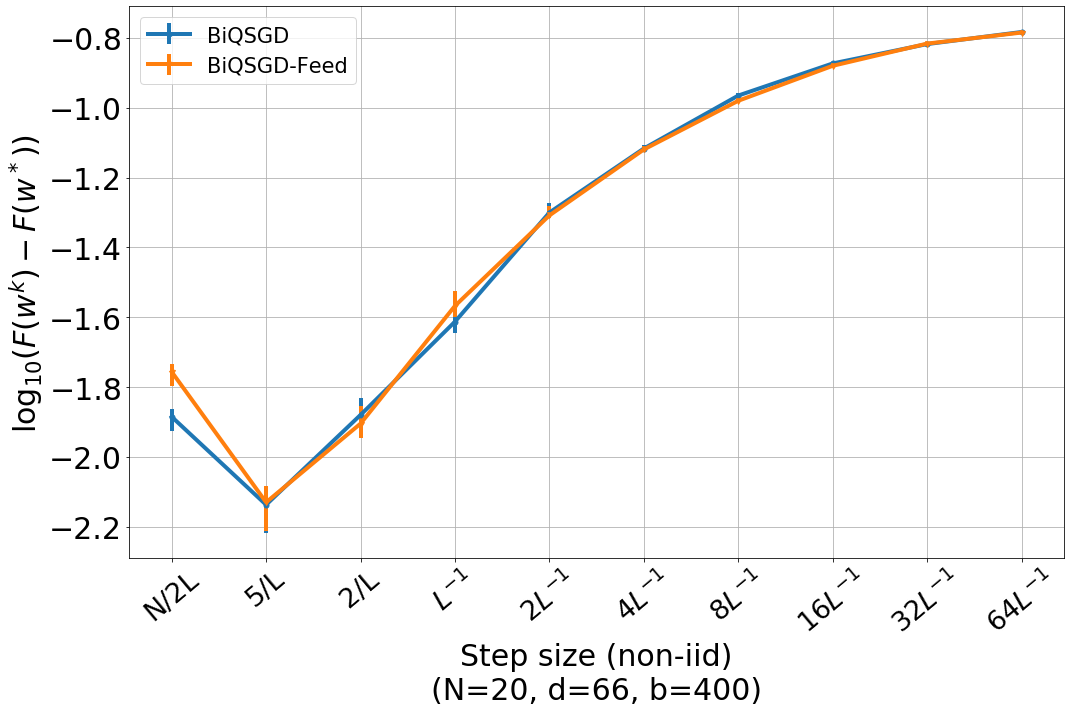

In [18]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Step size (non-iid)", one_on_two_points=False,
               xlabels=label_step_formula) 

### With averaging

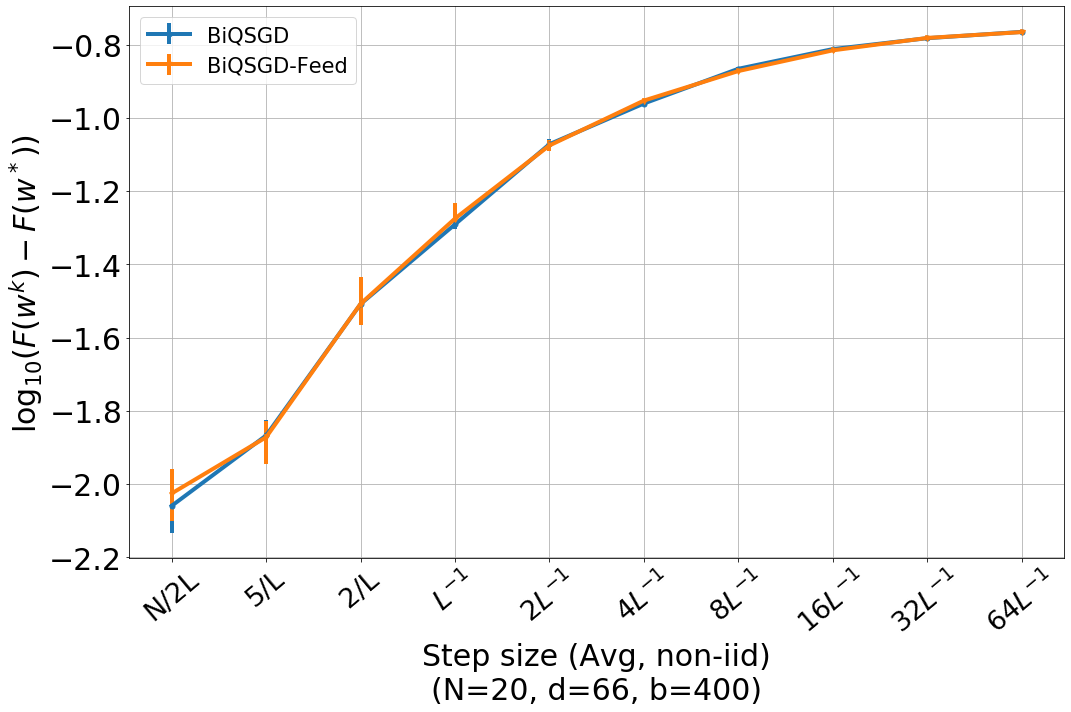

In [19]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Step size (Avg, non-iid)", one_on_two_points=False,
               xlabels=label_step_formula) 


### Display loss for each algorithm

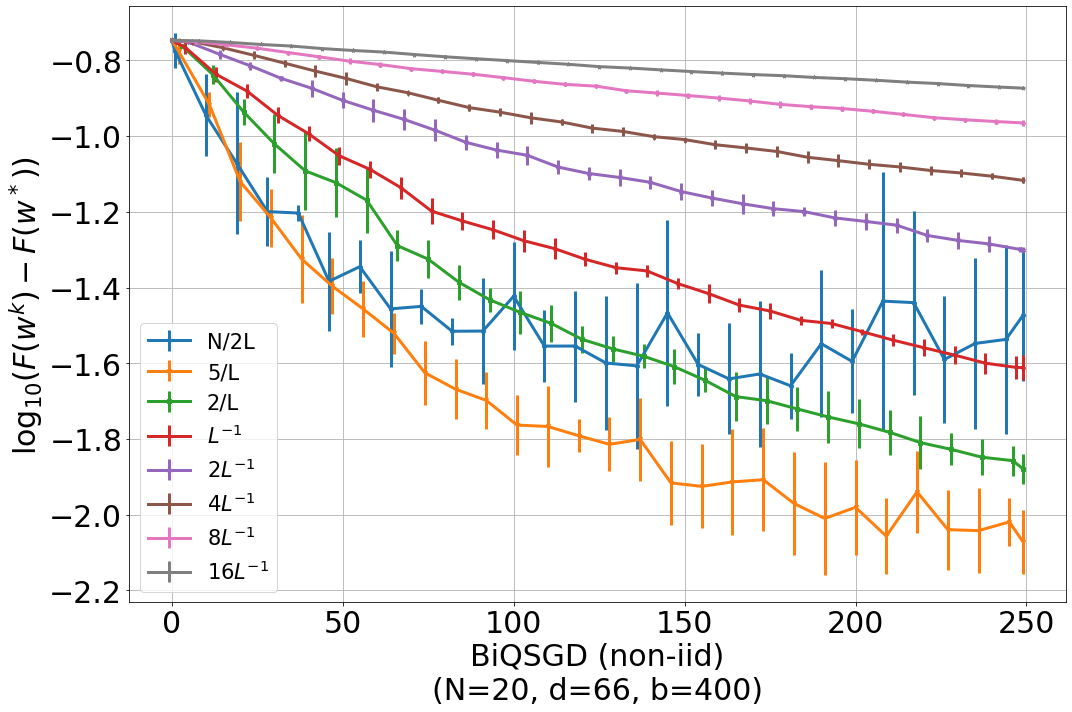

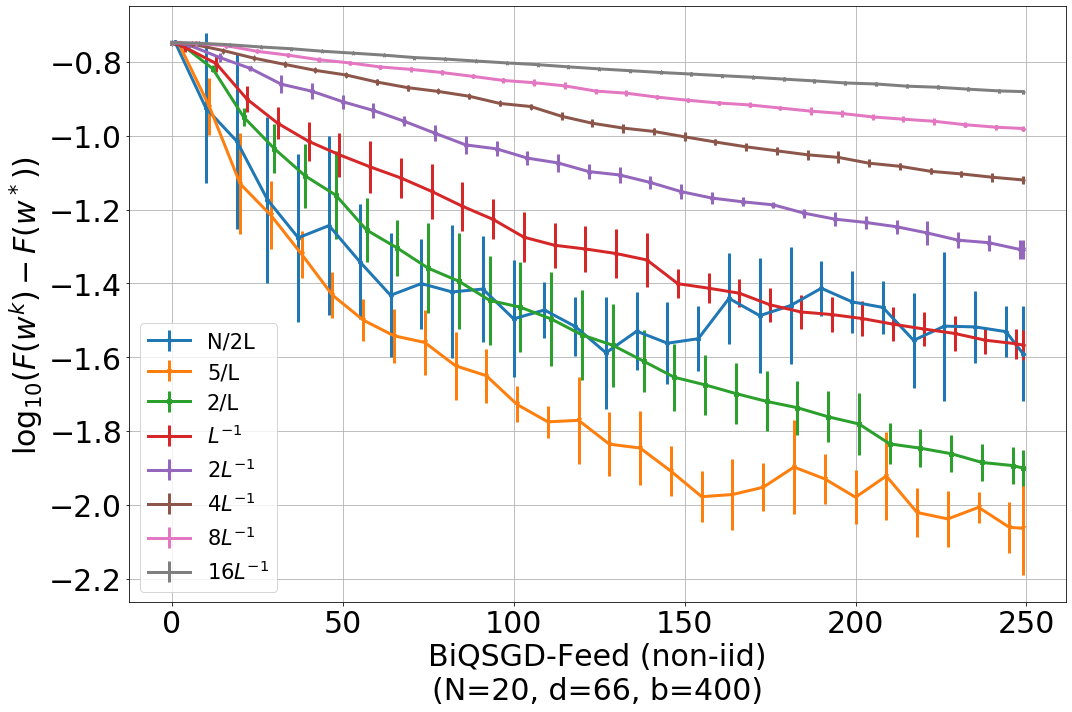

In [20]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-descent_by_algo_and_step_size".format(filename))
for algo_name, algo in res.items():
    plot_error_dist(algo.get_loss(obj), algo.names, algo.nb_devices_for_the_run, dim_notebook, 
                    batch_size=batch_size, all_error=algo.get_std(obj), x_legend="{0} (non-iid)".format(algo_name)) 


# All algorithms

In [24]:
%%time
batch_size = 400
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION_RANDOMIZED):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=False, stochastic=False, batch_size=batch_size, 
                                               nb_epoch=200, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-{1}".format(filename, batch_size))

100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


CPU times: user 3min 44s, sys: 1.88 s, total: 3min 46s
Wall time: 57 s


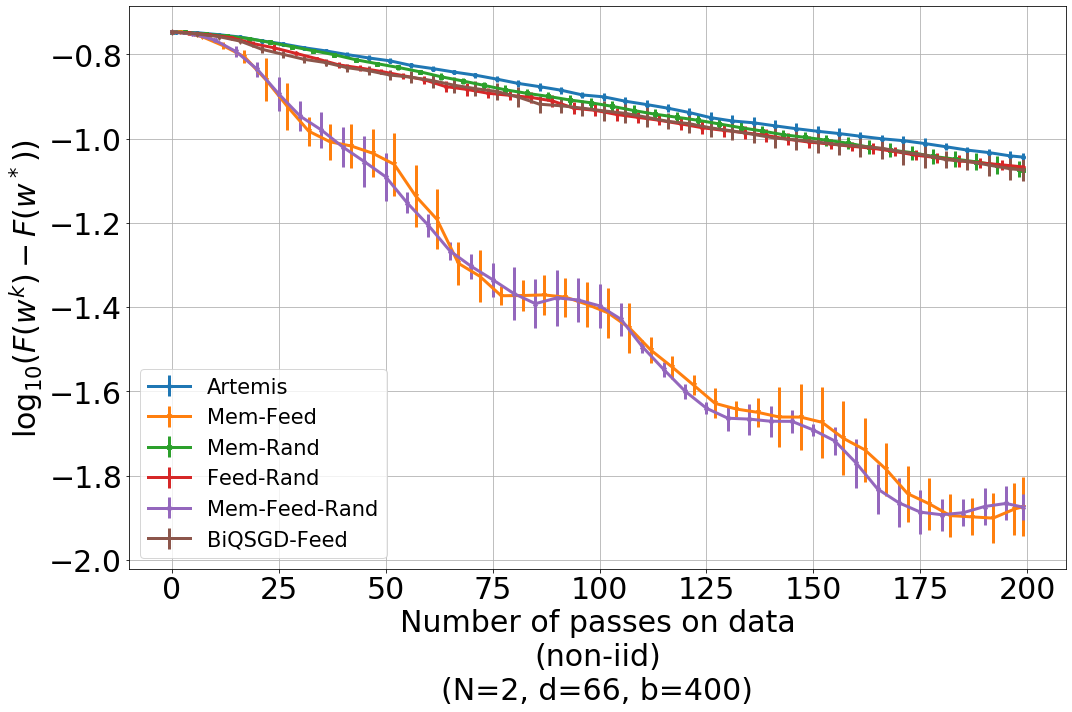

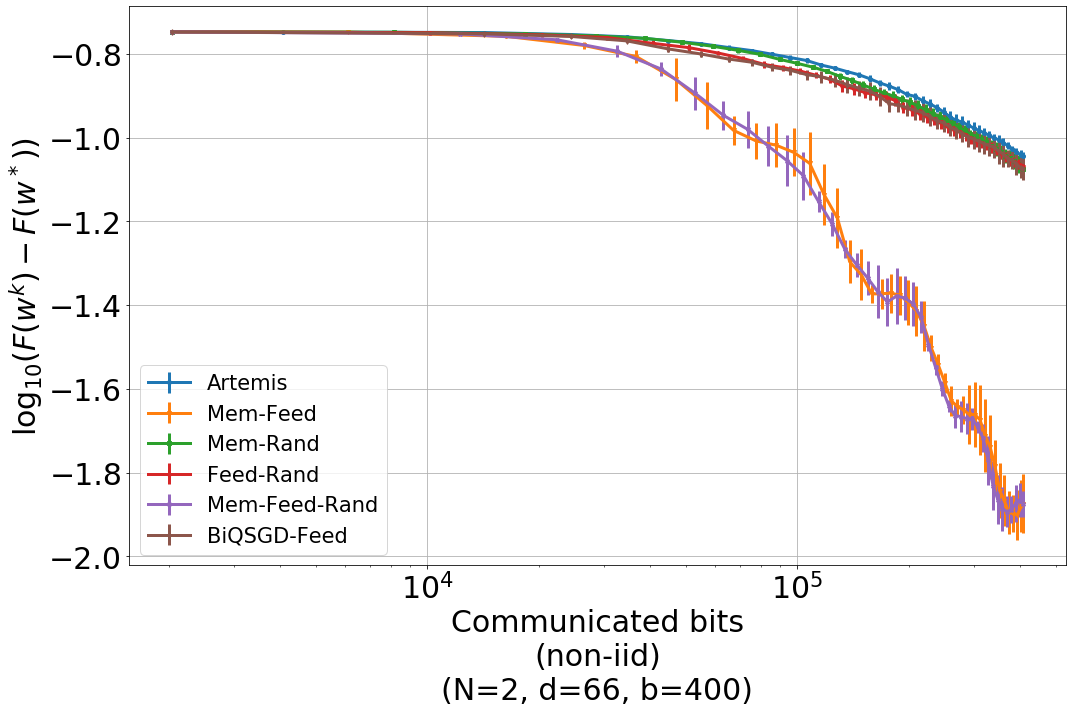

../src/utils/runner/ResultsOfSeveralDescents.py:85: RuntimeWarning: divide by zero encountered in log10
  log_e = [np.log10(e) for e in errors]


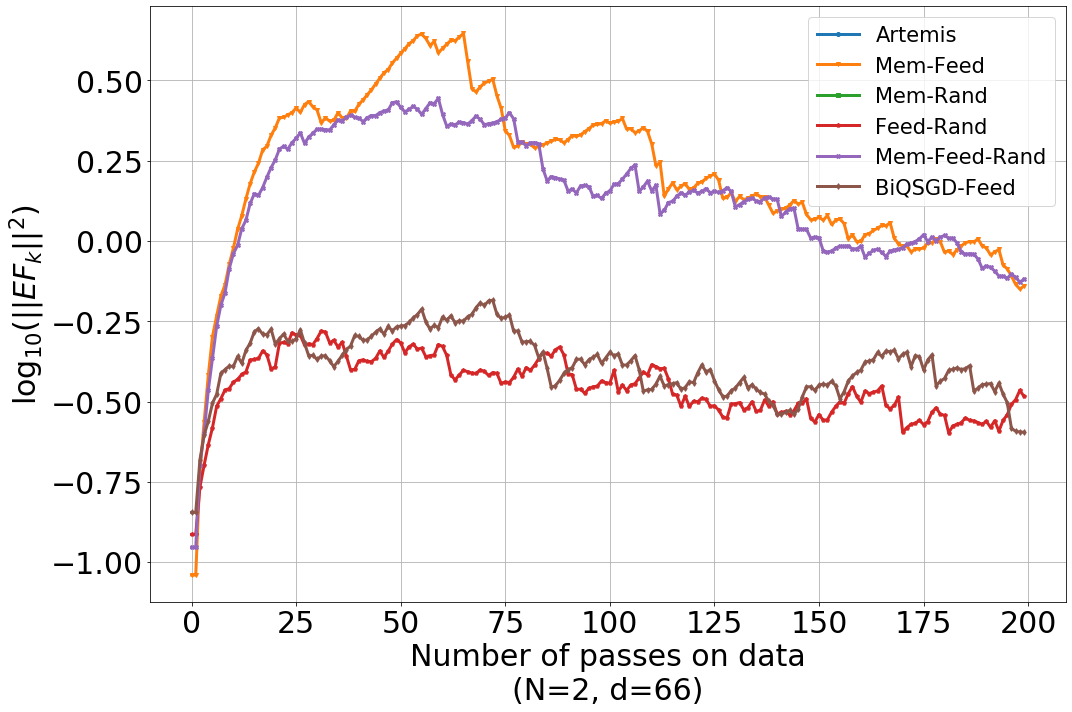

In [25]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

plot_error_dist(res.get_error_feedback(), res.names, res.nb_devices_for_the_run, dim_notebook,
                    ylegends=r"$\log_{10}(||EF_k||^2$)")